In [1]:
%run functions.ipynb
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Feature selection based on SAM

In [2]:
scoring = 'roc_auc'
cv = 4
cv_out = 5
cv_in = 2
n_iter = 100
n_jobs = 10

In [3]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [4]:
sam_filenames = get_sam_result_files()

In [5]:
sam_scores = {}
for filename in sam_filenames:
    models_logit_sam = fit_dim_reduction_pipeline(SAMSelection(filename=filename), {}, X_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
    _, _, roc_auc = calculate_roc_score(models_logit_sam, X_test, y_test)
    
    start_index = filename.rfind('_') + 1
    end_index = filename.rfind('.')
    sam_scores[int(filename[start_index:end_index])] = roc_auc

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklear

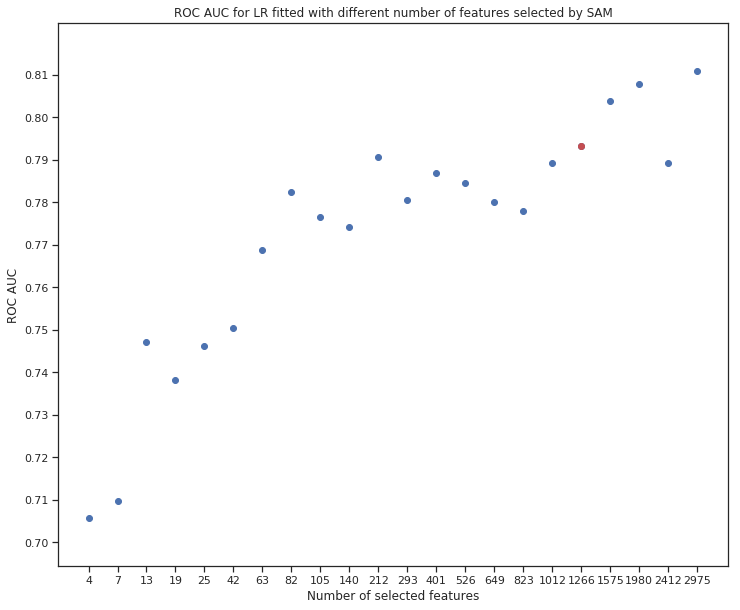

In [6]:
sorted_keys = sorted(sam_scores.keys())
key_names = [str(x) for x in sorted_keys]
figure(figsize = (12,10))
scatter(key_names, [sam_scores[key] for key in sorted_keys])
scatter(['1266'], [sam_scores[1266]], c='r')
yticks(np.arange(0.7, 0.82, 0.01))
xlabel('Number of selected features')
ylabel('ROC AUC')
title('ROC AUC for LR fitted with different number of features selected by SAM')
show()

In [7]:
print(sam_scores[13], sam_scores[82], sam_scores[212], sam_scores[1266])
significant_genes = np.genfromtxt("./../selection_results/sig_genes_13.csv", skip_header=1, delimiter=',', dtype=np.str)
significant_genes = [x.replace('"', '') for x in significant_genes]
print(significant_genes)

0.7470254565578307 0.7824432761483121 0.7906751521859435 0.7930962921970116
['LRIG1', 'ABAT', 'EVL', 'ELOVL5', 'IL6ST', 'TBC1D9', 'KIF13B', 'SIK3', 'MYB', 'CST3', 'FOS', 'CIRBP', 'SCUBE2']


### RFE using SVC

In [8]:
ranking = np.load('./../selection_results/svc_rfe_ranking.npy', allow_pickle=False)
ranking = ranking - 1

In [9]:
print(ranking, max(ranking), min(ranking))

[12178 12177 12176 ... 12052 12054 12056] 12178 0


In [10]:
ranked_feature_indices = [list(ranking).index(i) for i in np.arange(len(ranking))]
svc_rfe_scores = {}
for num_features in sorted_keys:
    logistic_params = {'C' : np.linspace(0.01, 1, 100), 'penalty' : ['l1'], 'solver' : ['liblinear']}
    logit_cv = RandomizedSearchCV(LogisticRegression(random_state=random_state), cv=cv, scoring=scoring, random_state=random_state,
                              n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 

    feature_indices = ranked_feature_indices[:num_features]
    logit_cv = logit_cv.fit(X_train[:, feature_indices], y_train)
    _, _, roc_auc = calculate_roc_score(logit_cv, X_test[:, feature_indices], y_test)
    svc_rfe_scores[num_features] = roc_auc

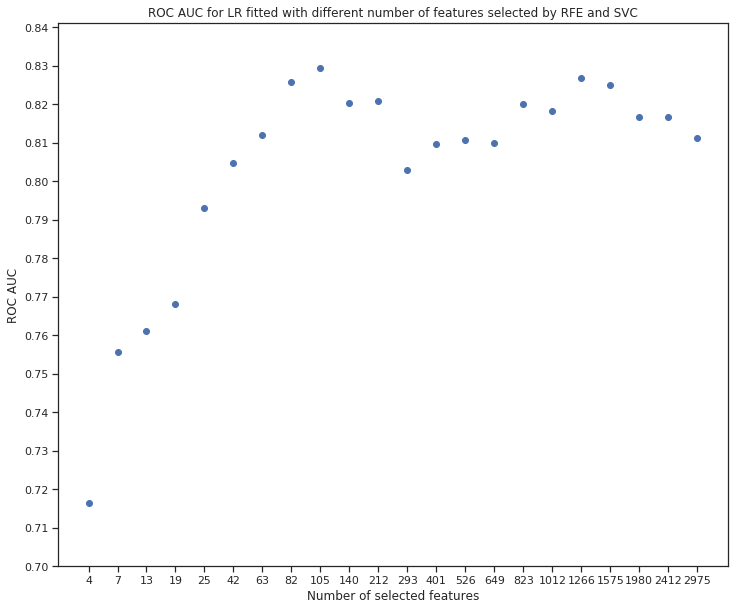

['ABAT', 'ADM', 'KCNK3', 'CXCL12', 'CALD1', 'AGPAT5', 'FOS', 'RB1CC1', 'PTPRA', 'HSPB1', 'HSPA2', 'SCRN1', 'SEPT9']


In [11]:
figure(figsize = (12,10))
scatter(key_names, [svc_rfe_scores[key] for key in sorted_keys])
xlabel('Number of selected features')
ylabel('ROC AUC')
yticks(np.arange(0.7, 0.84, 0.01))
title('ROC AUC for LR fitted with different number of features selected by RFE and SVC')
show()
significant_genes = [gene_names[i] for i in ranked_feature_indices[:13]]
print(significant_genes)

In [12]:
print(svc_rfe_scores[13], svc_rfe_scores[105], svc_rfe_scores[212], svc_rfe_scores[1266])

0.7610680686220255 0.8294133923630328 0.8207664637520753 0.826715550636414


### Number of common features selected

In [13]:
def intersection_count(k):
    sam = SAMSelection(filename='sig_genes_{}.csv'.format(k))
    sam.fit(X_train, y_train)
    set1 = set(sam.significant_genes_indices)
    set2 = set(ranked_feature_indices[:k])
    return len(set1.intersection(set2))

In [14]:
for num_features in sorted_keys:
    print("{} : {}".format(num_features, intersection_count(num_features)))

4 : 1
7 : 1
13 : 2
19 : 2
25 : 3
42 : 7
63 : 10
82 : 13
105 : 14
140 : 17
212 : 26
293 : 31
401 : 43
526 : 64
649 : 84
823 : 108
1012 : 141
1266 : 198
1575 : 287
1980 : 431
2412 : 602
2975 : 874


In [ ]:
num_random = 30
random_scores = {}
for num_features in sorted_keys:
    random_scores[num_features] = []
    for _ in range(num_random):
        ranking = np.arange(X_train.shape[1])
        np.random.shuffle(ranking)
        ranked_feature_indices = [list(ranking).index(i) for i in np.arange(len(ranking))]
        
        logistic_params = {'C' : np.linspace(0.01, 1, 100), 'penalty' : ['l1'], 'solver' : ['liblinear']}
        logit_cv = RandomizedSearchCV(LogisticRegression(random_state=random_state), cv=cv, scoring=scoring, random_state=random_state,
                                  n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 

        feature_indices = ranked_feature_indices[:num_features]
        logit_cv = logit_cv.fit(X_train[:, feature_indices], y_train)
        _, _, roc_auc = calculate_roc_score(logit_cv, X_test[:, feature_indices], y_test)
        random_scores[num_features] += [roc_auc]

In [ ]:
figure(figsize = (12,10))
stds = [np.std(random_scores[key]) for key in sorted_keys]
means = [np.mean(random_scores[key]) for key in sorted_keys]
errorbar(key_names, means, yerr=stds, linestyle='None', fmt='o', capsize=5, barsabove=False)
xlabel('Number of selected features')
ylabel('ROC AUC')
title('ROC AUC for LR fitted with different number of randomly selected features')
show()

In [ ]:
figure(figsize = (12,10))
scatter(key_names, [sam_scores[key] for key in sorted_keys], label='SAM')
scatter(['1266'], [sam_scores[1266]], c='r', label='SAM (FDR = 0)')
scatter(key_names, [svc_rfe_scores[key] for key in sorted_keys], label='RFE and SVC')
errorbar(key_names, means, yerr=stds, linestyle='None', fmt='o', capsize=5, 
         barsabove=False, label='Random features', c='g')
xlabel('Number of selected features')
ylabel('ROC AUC')
yticks(np.arange(0.5, 0.85, 0.02))
legend(loc='lower right')
title('Feature selection methods')
show()